In [1]:
import pygor.filehandling
#import pygor.load
import pygor.strf.analyse

# External
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os 
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
%reload_ext autoreload
%autoreload 2
# Test
user = pathlib.Path(os.getcwd()).parents[-3].stem
user

'Simen'

In [2]:
pkls = pygor.filehandling.find_files_in(".pkl", fr"c:\Users\{user}\OneDrive\Data\Pickles", recursive=True)
loaded = pygor.filehandling.pickleload_objects(pkls)

Iterating through and loading listed .pkl files as objects:   0%|          | 0/17 [00:00<?, ?it/s]

Output()

C:\Users\Simen\Git_repos\pygor\src\pygor\utilities.py:173: UserWarning: Destructive method. You lose data, with no way of recovering original shape!
  warnings.warn("Destructive method. You lose data, with no way of recovering original shape!")


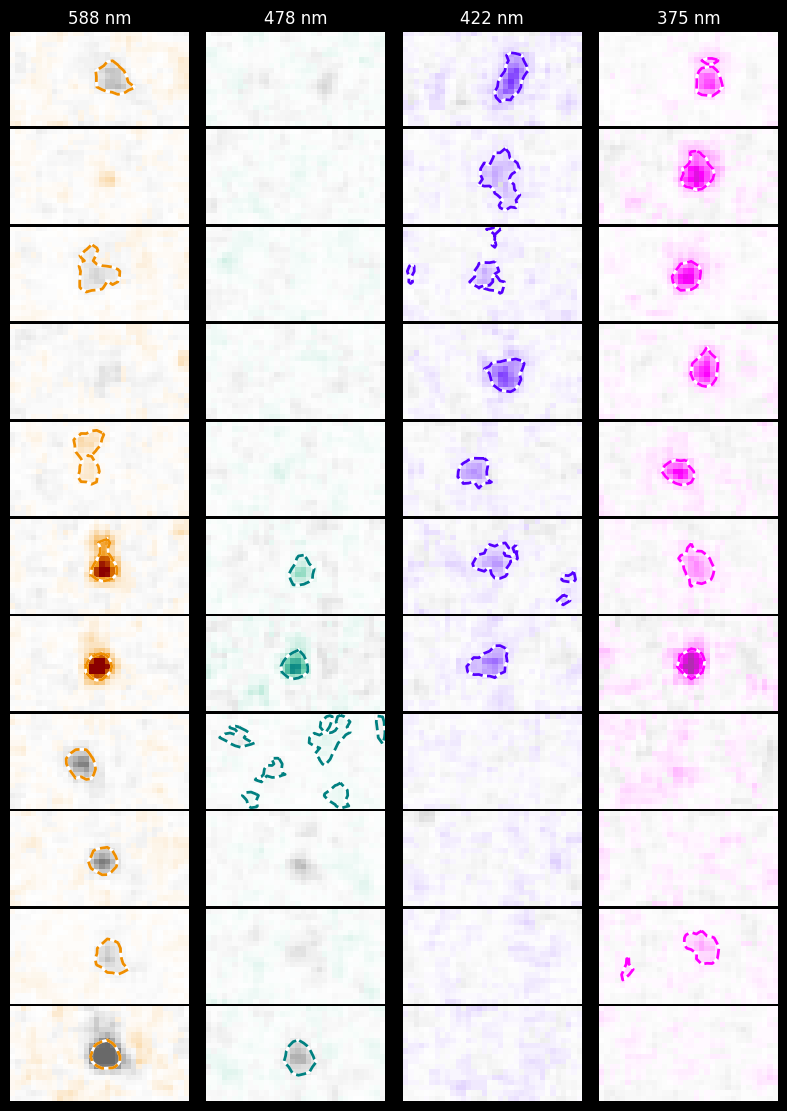

In [12]:
pygor.strf.plot.chroma_overview(loaded[0], None, contours = True)

In [4]:
import skimage


'\nTODO Write this into a final contour() function\nAlso need to split by polarity of signal within that function, and plot accordingly\n--> Maybe I can do this by getting the polarity of the timecourse of the pixels by masked regions \n    - This will reduce the chance of false positives, but only if the regions remain separated...\n'

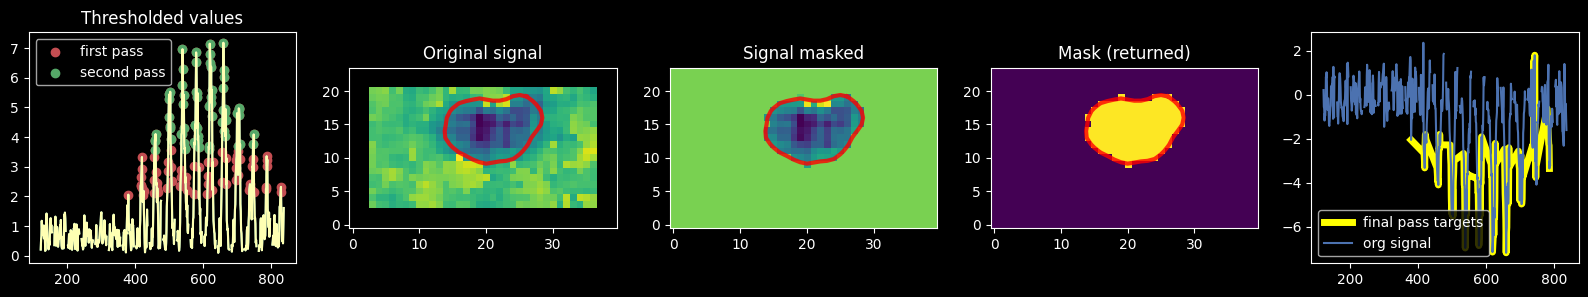

In [408]:

def _detect_targets(spatial_filter, thresh_value = 2.5, result_plot = False, **kwargs):
    """
    Detect targets in a spatial filter based purely on amplitude. Does not account for spatial position.

    Parameters
    ----------
    spatial_filter : _type_
        _description_
    """
     # Detect targets
    spatial_filter_abs_flat = np.abs(spatial_filter).flatten()
    detected_targets_firstpass = np.where(spatial_filter_abs_flat > thresh_value)[0]
    if len(detected_targets_firstpass) == 0: 
        detected_targets = []
    else:
        level_set_abs = np.median(spatial_filter_abs_flat[detected_targets_firstpass])
        detected_targets = np.where(spatial_filter_abs_flat > level_set_abs)[0]
    if result_plot:
        if kwargs.get("ax") is None:
            fig, ax = plt.subplots(1,1, figsize = (5, 3))
        else:
            ax = kwargs.get("ax")
        ax.plot(np.abs(spatial_filter).flatten())
        ax.plot(spatial_filter_abs_flat)
        ax.scatter(detected_targets_firstpass, spatial_filter_abs_flat[detected_targets_firstpass], c="r", label = "first pass")
        ax.scatter(detected_targets, spatial_filter_abs_flat[detected_targets], c="g", label = "second pass")
        ax.legend()
        ax.set_title("Thresholded values")
    return detected_targets

def _gen_filter_mask(spatial_filter, thresh_value = 2.5, min_hole_size = 2, min_object_size = 3, result_plot = False, **kwargs):
    """
    Generates a mask for the spatial filter by detecting targets based on amplitude, 
    removing small holes and objects to improve the percision, and then dialating the 
    mask with a 5x5 circular footprint under the hueristic that true target signals should
    be close to each other.

    Parameters
    ----------
    spatial_filter : _type_
        _description_
    """
    # Keep track of input shape (for reshaping)
    shape = spatial_filter.data.shape
    targets = _detect_targets(spatial_filter, thresh_value = thresh_value)
    # Mask processing
    mask = np.zeros(len(spatial_filter.flatten()))
    mask[targets] = 1
    mask = mask.astype(int).reshape(shape)
    mask = skimage.morphology.remove_small_holes(mask, area_threshold = min_hole_size)
    mask = skimage.morphology.remove_small_objects(mask, min_size = min_object_size)
    # mask = skimage.morphology.binary_dilation(mask, footprint = [[0, 0, 1, 0, 0],
    #                                                              [0, 1, 1, 1, 0],
    #                                                              [1, 1, 1, 1, 1],
    #                                                              [0, 1, 1, 1, 0], 
    #                                                              [0, 0, 1, 0, 0]])
    # Double dialation is intentional
    mask = skimage.morphology.binary_dilation(mask)
    mask = skimage.morphology.binary_dilation(mask)

    if result_plot:
        # Apply mask to signal and output 
        spatial_filter_output = np.copy(spatial_filter.flatten())
        spatial_filter_output[~mask.flatten()] = 0
        spatial_filter_output = spatial_filter_output.reshape(shape)
        if kwargs.get("ax") is None:
            fig, ax = plt.subplots(1, 3, figsize = (20, 4))
        else:
            ax = kwargs.get("ax")
        images = [spatial_filter, spatial_filter_output, mask]
        titles = ["Original signal", "Signal masked", "Mask (returned)"]
        for n, a in enumerate(ax.flat):
            if a == ax[-1]:
                non_zero_spatial_filter = spatial_filter.flatten()[spatial_filter.flatten()!=~0]
                post_processing_tarets = np.where(mask.flatten() == 1)[0]
                plt.plot(post_processing_tarets, non_zero_spatial_filter[post_processing_tarets], c="yellow", 
                    label = "final pass targets", lw = 5, dash_joinstyle = "miter")
                plt.plot(non_zero_spatial_filter, c="b", label = "org signal")
                #plt.scatter(post_processing_tarets, non_zero_spatial_filter[post_processing_tarets], c="b",  s = 2, label = "final pass targets")
                #plt.scatter(targets, non_zero_spatial_filter[targets], c="g", label = "second pass targets", s=2)
                plt.legend()
            else:
                a.imshow(images[n], origin = "lower")
                a.set_title(titles[n])
    return mask

def _fit_filter_contour(spatial_filter_mask, gauss_sigma = 1,result_plot = False, **kwargs):
    spatial_filter_mask = skimage.filters.gaussian(spatial_filter_mask, sigma = gauss_sigma, mode = "nearest")
    contour = skimage.measure.find_contours(spatial_filter_mask)
    if result_plot:
        if kwargs.get("color") is not None: 
            kwargs["c"] = kwargs["color"]
        if kwargs.get("c") is None:
            kwargs["c"] = "red"
        if kwargs.get("ax") is None:
            fig, ax = plt.subplots(1, 1, figsize = (10, 5))
            ax
            ax.imshow(spatial_filter_mask, origin = "lower")
            for contour_n in contour:
                ax.plot(contour_n[:, 1], contour_n[:, 0], lw = 3, ls = '-',alpha = .8, c = kwargs["c"])
            plt.show()
        else:
            ax = kwargs.get("ax")
            for a in ax[:3]:
                for contour_n in contour:
                    a.plot(contour_n[:, 1], contour_n[:, 0], lw = 3, ls = '-',alpha = .8, c = kwargs["c"])
    return contour

rec = 1
roi = 0 #rec 8 roi 10 is dual pol
fig, ax = plt.subplots(1, 5, figsize = (20, 3))
_ = _detect_targets(loaded[rec].collapse_times()[roi], thresh_value = 2, result_plot=1, ax = ax.flat[0])
zzz = _gen_filter_mask(loaded[rec].collapse_times()[roi], result_plot=1, ax = ax.flat[1:])
_ = _fit_filter_contour(zzz, result_plot=1, ax = ax.flat[1:])

"""
TODO Write this into a final contour() function
Also need to split by polarity of signal within that function, and plot accordingly
--> Maybe I can do this by getting the polarity of the timecourse of the pixels by masked regions 
    - This will reduce the chance of false positives, but only if the regions remain separated...
"""
# contour = skimage.measure.find_contours(filter_mask, level = .5)
# mask_time = np.ma.average(np.ma.masked_array(loaded[rec].strfs[roi], mask = 
#     np.repeat(np.expand_dims(mask, axis = 0), 20, axis = 0)), axis = (1, 2)_

c:\Users\Simen\miniconda3\envs\strfclone\lib\site-packages\numpy\core\fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
c:\Users\Simen\miniconda3\envs\strfclone\lib\site-packages\skimage\_shared\utils.py:157: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  return func(*args, **kwargs)


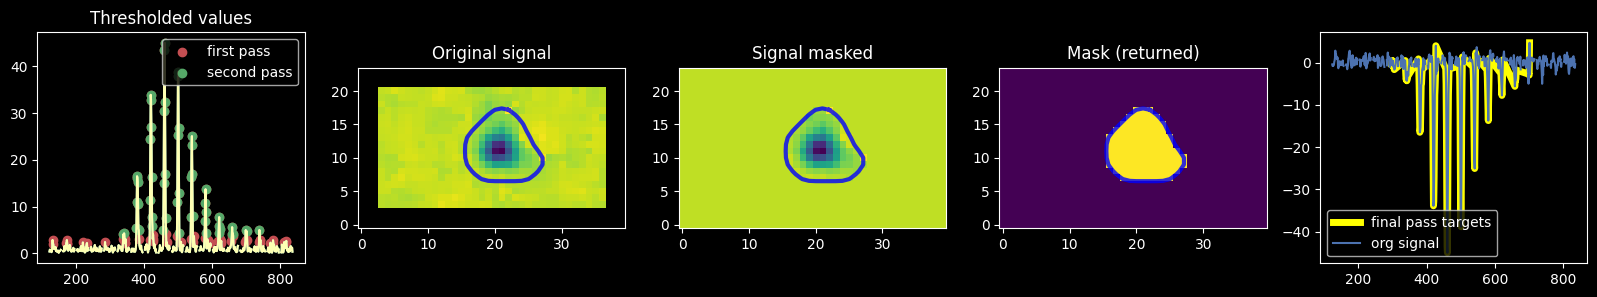

In [407]:
def contour_on_processed_mask(spatial_filter, plot_results = False, **kwargs):
    # Get mask first
    if plot_results is True:
        fig, ax = plt.subplots(1, 5, figsize = (20, 3))
        _ = _detect_targets(spatial_filter, thresh_value = 2, result_plot=1, ax = ax.flat[0])
        mask = _gen_filter_mask(spatial_filter, result_plot=1, ax = ax.flat[1:])
    else:
        mask = _gen_filter_mask(spatial_filter)
    # Then, segment the mask into its constituent parts
    mask_labeled = skimage.measure.label(mask)
    # Loop logic: Sort the labelled mask into positive and negative masks, then combine separately
    unique_labels = np.unique(mask_labeled)
    unique_labels = unique_labels[unique_labels > 0]
    # Keeping track of some stats for troubleshooting
    label_polarity = []
    label_value = []
    # Loop through the unique labels and append the masks accordingly
    neg_mask = []
    pos_mask = []
    for n, label in enumerate(unique_labels):
        # Get the average value within the labelled region of the mask
        current_mask_vals = spatial_filter[mask_labeled == label]
        label_average = np.average(current_mask_vals)
        label_value.append(label_average)
        # Append the mask accordingly
        if label_average > 0:
            label_polarity.append(1)
            pos_mask.append(np.where(mask_labeled == label, 1, 0))
        else:
            label_polarity.append(-1)
            neg_mask.append(np.where(mask_labeled == label, 1, 0))
    # Sum to combine the masks according to polarity
    if neg_mask == []:
        neg_mask = np.ones(mask.shape)
    else:
        neg_mask = np.sum(np.array(neg_mask), axis = 0)
    if pos_mask == []:
        pos_mask = np.ones(mask.shape)
    else:
        pos_mask = np.sum(np.array(pos_mask), axis = 0)
    # Throw error if overlap exists
    if np.any(neg_mask > 1) or np.any(pos_mask > 1):
        raise ValueError("Masking logic insufficient, leading to overlapping masks. Manual fix required.")
    # Contour seperately based on polarity
    # neg_contours = _fit_filter_contour(neg_mask)
    if plot_results is True:
        neg_contours = _fit_filter_contour(neg_mask, result_plot = plot_results, ax = ax[1:], c = "blue", **kwargs)
        pos_contours = _fit_filter_contour(pos_mask, result_plot = plot_results, ax = ax[1:], c = "red", **kwargs)
    else:
        neg_contours = _fit_filter_contour(neg_mask)
        pos_contours = _fit_filter_contour(pos_mask)
    return (neg_contours, pos_contours)
rec = 0
roi = 0
a, b = contour_on_processed_mask(loaded[rec].collapse_times()[roi], plot_results= True)

In [381]:
pygor.plotting.play_movie(loaded[rec].strfs[roi])

In [ ]:
ax[1:3]

array([<AxesSubplot: >, <AxesSubplot: >], dtype=object)

Levelset: 4.050883978502711 -3.8952625304786883


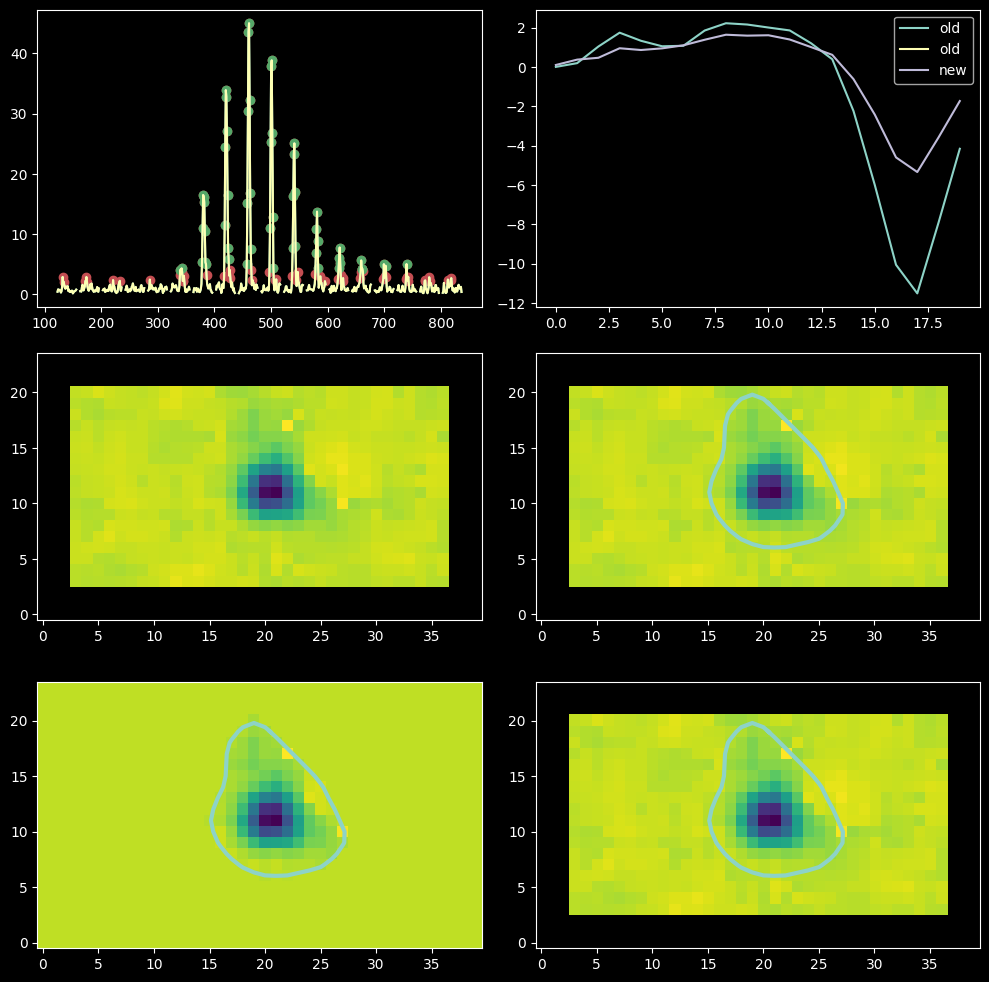

In [ ]:
# Testing
rec = 0
roi = 0
# Give input
signal = loaded[rec].collapse_times()[roi]
#signal_neg = np.clip(loaded[rec].collapse_times()[roi], a_min = None, a_max = 0)
#signal = np.clip(loaded[rec].collapse_times()[roi], a_min = 0, a_max = None)
#signal = np.var(loaded[rec].strfs[roi], axis = 0)
shape = signal.data.shape
# Detect targets
signal_flat_abs = np.abs(signal.flatten())
detected_targets_firstpass = np.where(signal_flat_abs >= 2)[0]
if len(detected_targets_firstpass) == 0: 
    detected_targets_secondpass = []
else:
    level_set_abs = np.median(signal_flat_abs[detected_targets_firstpass])
    level_set = np.median(signal.flatten()[detected_targets_firstpass])
    detected_targets_secondpass = np.where(signal_flat_abs > level_set_abs)[0]
# Mask processing
mask = np.ones(len(signal.flatten()))
mask[detected_targets_secondpass] = 0
mask = mask.astype(int).reshape(shape)
mask = skimage.morphology.remove_small_holes(mask, area_threshold = 4)
mask = skimage.morphology.remove_small_objects(mask, min_size = 2)
cross_struct = [[0, 0, 1, 0, 0],
 [0, 1, 1, 1, 0],
 [1, 1, 1, 1, 1],
 [0, 1, 1, 1, 0],
 [0, 0, 1, 0, 0]]
mask = skimage.morphology.binary_erosion(mask, footprint=cross_struct)
#mask = skimage.morphology.binary_erosion(mask)
# Apply mask to signal and output 
signal_output = np.copy(signal.flatten())
signal_output[mask.flatten()] = 0
signal_output = signal_output.reshape(shape)
mask_time = np.ma.average(np.ma.masked_array(loaded[rec].strfs[roi], mask = 
    np.repeat(np.expand_dims(mask, axis = 0), 20, axis = 0)), axis = (1, 2))
filter_mask = skimage.filters.gaussian(mask, sigma = 1, mode = "nearest")
# Plot
fig, ax = plt.subplots(3, 2, figsize = (10, 10))
ax[0, 0].plot(np.abs(signal).flatten())
ax[0, 0].plot(signal_flat_abs)
ax[0, 0].scatter(detected_targets_firstpass, signal_flat_abs[detected_targets_firstpass], c="r")
ax[0, 0].scatter(detected_targets_secondpass, signal_flat_abs[detected_targets_secondpass], c="g")
ax[0, 1].plot(loaded[rec].get_timecourses()[roi].T, label = "old")
ax[0, 1].plot(mask_time, label = "new")
ax[0, 1].legend()
ax[1, 0].imshow(loaded[rec].collapse_times()[roi], origin = "lower")
ax[1, 1].imshow(signal.reshape(shape), origin = "lower")
ax[2, 0].imshow(signal_output, origin = "lower")
ax[2, 1].imshow(loaded[rec].collapse_times()[roi], origin = "lower")
#contour = skimage.measure.find_contours(signal_output, level = level_set)
contour = skimage.measure.find_contours(filter_mask, level = .5)
for contour_n in contour:
    ax[1,1].plot(contour_n[:, 1], contour_n[:, 0], lw = 3, ls = '-',)
    ax[2,1].plot(contour_n[:, 1], contour_n[:, 0], lw = 3, ls = '-',)
    ax[2,0].plot(contour_n[:, 1], contour_n[:, 0], lw = 3, ls = '-',)

print("Levelset:", level_set_abs, level_set)
fig.tight_layout()

C:\Users\simen\PhD\pygor\src\pygor\strf\contouring.py:188: UserWarning: Passed array did not meet absolute threshold criteria of 2.5
  contour_lower, contour_upper = _draw_contour_bipolar(arr_2d, abs_criteria)
C:\Users\simen\PhD\pygor\src\pygor\strf\contouring.py:188: UserWarning: Passed array did not meet absolute threshold criteria of 2.5
  contour_lower, contour_upper = _draw_contour_bipolar(arr_2d, abs_criteria)
C:\Users\simen\PhD\pygor\src\pygor\strf\contouring.py:188: UserWarning: Passed array did not meet absolute threshold criteria of 2.5
  contour_lower, contour_upper = _draw_contour_bipolar(arr_2d, abs_criteria)
C:\Users\simen\PhD\pygor\src\pygor\strf\contouring.py:188: UserWarning: Passed array did not meet absolute threshold criteria of 2.5
  contour_lower, contour_upper = _draw_contour_bipolar(arr_2d, abs_criteria)
C:\Users\simen\PhD\pygor\src\pygor\strf\contouring.py:188: UserWarning: Passed array did not meet absolute threshold criteria of 2.5
  contour_lower, contour_up

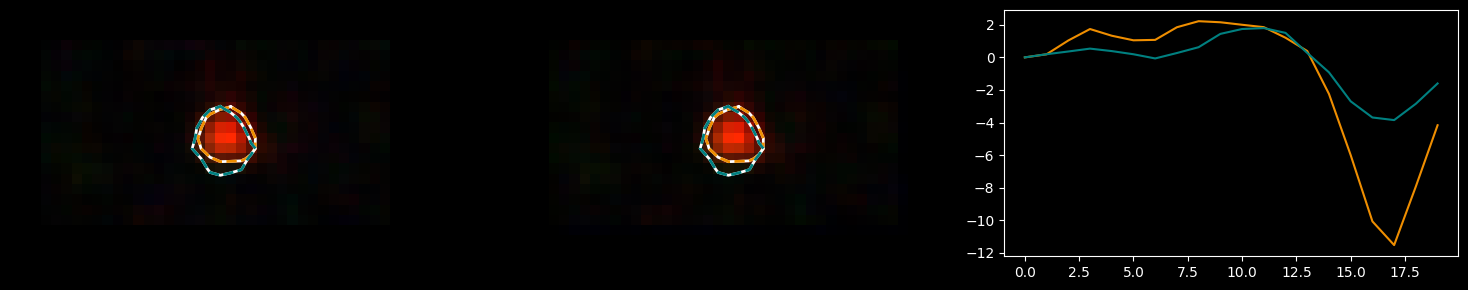

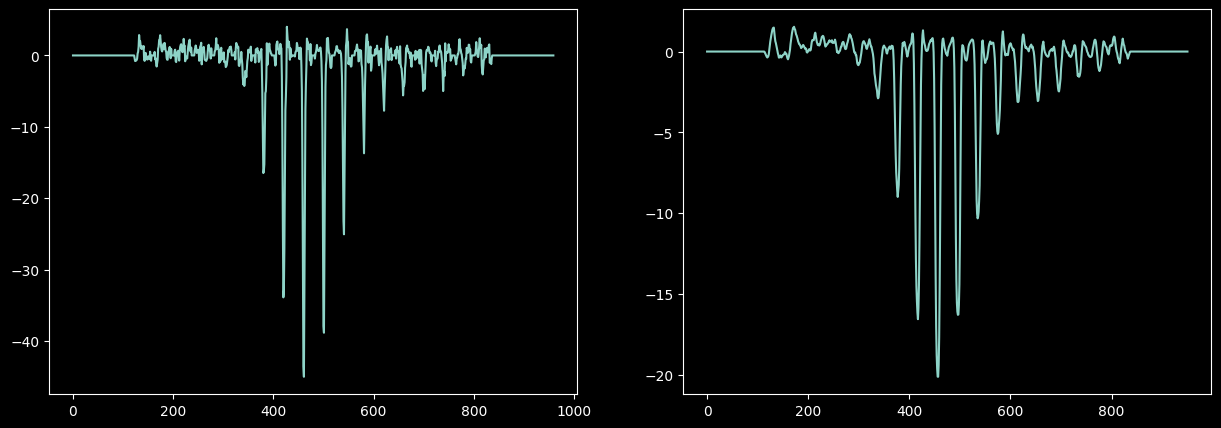

In [4]:



def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

roi = 0
rec = 0
signal = loaded[rec].collapse_times()[roi].data.flatten()
sliding_mean = running_mean(signal, 10)
#sliding_mean_sum = np.sum(sliding_mean)

pygor.strf.plot.visualise_summary(loaded[rec], specify_rois=roi);
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(signal)
ax[1].plot(sliding_mean)
#plt.axhline(sliding_mean_sum, 0, color = "r", alpha = 0.5)

# FAST ICA 

In [14]:
n_c = 10
model = sklearn.decomposition.TruncatedSVD(n_components = n_c, algorithm="arpack")
model.fit(inpu_arr)
s = model.transform(inpu_arr)
biggest_comp = np.unravel_index(np.argmax(np.abs(model.components_)), model.components_.shape)
recovered = model.components_[biggest_comp[0]]

NameError: name 'fig' is not defined

In [184]:
rec = 0
roi = 6
inpu_arr = loaded[rec].get_pix_times()[roi]
n_c = 10
model = sklearn.decomposition.TruncatedSVD(n_components = n_c)
model.fit(inpu_arr)
s = model.transform(inpu_arr)
fig.colorbar(org, ax = ax[1,0])
biggest_comp = np.unravel_index(np.argmax(np.abs(model.components_)), model.components_.shape)
recovered = model.components_[biggest_comp[0]]
# comps = ax[1,1].imshow(model.components_[0].reshape(24, 40))
fig, ax = plt.subplots(3, 2, figsize = (15, 15))
ax[0,0].plot(loaded[rec].get_timecourses()[roi].T)
ax[0,1].plot(s)
org = ax[1,0].imshow(loaded[rec].collapse_times()[roi])
comps = ax[1,1].imshow(recovered.reshape(24, 40))
fig.colorbar(comps, ax = ax[1,1])
ax[2,0].plot(loaded[rec].collapse_times()[roi].data.flatten())
ax[2,1].plot(recovered.flatten())

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [37]:
biggest_comp

(0, 461)

In [38]:
pygor.plotting.play_movie(model.components_.reshape(n_c, 24, 40))

2024-04-24 13:30:51,873 INFO Animation.save using <class 'matplotlib.animation.HTMLWriter'>


In [767]:
pygor.plotting.play_movie(loaded[rec].strfs[roi])

2024-04-23 16:17:46,753 INFO Animation.save using <class 'matplotlib.animation.HTMLWriter'>


In [532]:
transformed.shape

(20, 2)

# CFAR experimentation

In [52]:
def cfar_detector(x, num_train, num_guard, rate_fa):
    """
    Detect peaks with CFAR algorithm.
    
    num_train: Number of training cells.
    num_guard: Number of guard cells.
    rate_fa: False alarm rate. 
    """
    num_cells = x.size
    num_train_half = round(num_train / 2)
    num_guard_half = round(num_guard / 2)
    num_side = num_train_half + num_guard_half
 
    alpha = num_train*(rate_fa**(-1/num_train) - 1) # threshold factor
    
    peak_idx = []
    for i in range(num_side, num_cells - num_side):
        
        if i != i-num_side+np.argmax(x[i-num_side:i+num_side+1]): 
            continue
        
        sum1 = np.sum(x[i-num_side:i+num_side+1])
        sum2 = np.sum(x[i-num_guard_half:i+num_guard_half+1]) 
        p_noise = (sum1 - sum2) / num_train 
        threshold = alpha * p_noise
        
        if x[i] > threshold: 
            peak_idx.append(i)
    
    peak_idx = np.array(peak_idx, dtype=int)
    
    return peak_idx


In [150]:
import skimage.morphology
import skimage.filters
import scipy

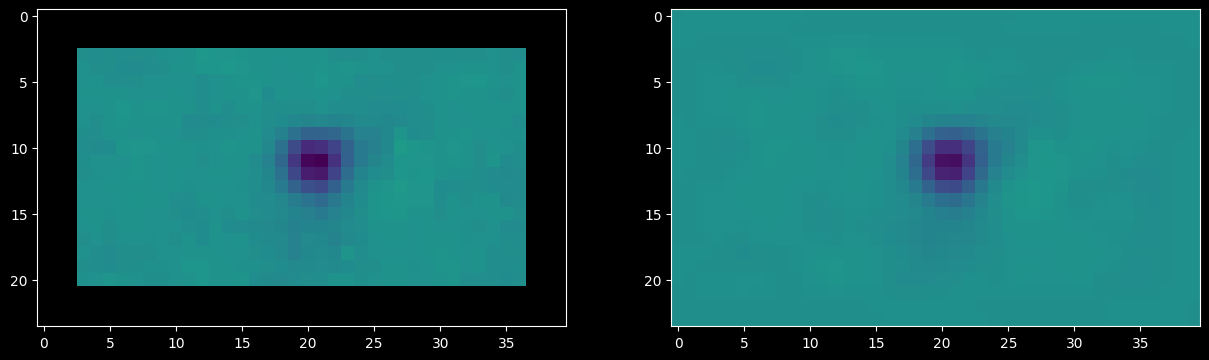

In [234]:
signal_manipulated = skimage.filters.butterworth(loaded[rec].collapse_times()[roi], .3, high_pass = False)
fig, ax = plt.subplots(1, 2, figsize = (15, 7.5))
ax[0].imshow(loaded[rec].collapse_times()[roi])
ax[1].imshow(signal_manipulated)
abs_max = np.max(np.abs(loaded[rec].collapse_times()[roi]))
for ax in ax.flat:
    for im in ax.axes.images:
        im.set_clim(-abs_max, abs_max)

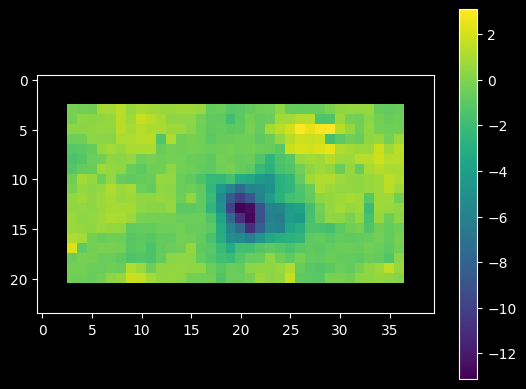

In [1147]:
plt.imshow(signal)
plt.colorbar()